# House Price Competition

# Step 1 - Basics

In [1]:
#1.1 Imports
import pandas as pd
import numpy as np
import warnings

from pathlib import Path
import matplotlib.pyplot as plt

from pandas.api.types import CategoricalDtype

from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns


#Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

warnings.filterwarnings('ignore')

C:\Users\banya\AppData\Local\Temp\ipykernel_4092\2870382901.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [2]:
#1.2 Investigation
train_inv = pd.read_csv('../Documents/Gergely dolgok/AI/0 Datasets/HP comp/train.csv', index_col = 'Id')
train_inv.head()
train_inv.shape

#Missing Values
train_inv.isnull().sum().sort_values(ascending = False)
length = train_inv.shape[0]
bmark_90 = length*0.9
miss_above_90 = [col for col in train_inv.columns if train_inv[col].isnull().sum() > bmark_90]

#Cardinality
train_inv.select_dtypes('object').nunique().sort_values(ascending = False)
object_cols = [col for col in train_inv.select_dtypes('object')]
high_card_cols = [col for col in train_inv.select_dtypes('object') if train_inv[col].nunique() >= 10]
low_card_cols = list(set(object_cols) - set(high_card_cols))
len(low_card_cols)

40

In [3]:
miss_above_90

['Alley', 'PoolQC', 'MiscFeature']

In [4]:
train_inv.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#1.3 Load Data
#Function
def load_data():
    #read the data
    datadir = Path('../Documents/Gergely dolgok/AI/0 Datasets/HP comp/')
    df_train = pd.read_csv(datadir/'train.csv', index_col = 'Id')
    df_test = pd.read_csv(datadir/'test.csv', index_col = 'Id')
    #drop rows with missing Target from df_train
    df_train.dropna(axis = 0, subset = ['SalePrice'], inplace = True)
    #concat
    df = pd.concat([df_train, df_test])
    
    df = clean(df)
    df = encode(df)
    df = impute(df)
    
    #Resplit to df_train and df_test
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_train.index, :]
    
    return df_train, df_test
    

In [6]:
train_inv.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [7]:
#Clean
def clean(df):
    #replace
    df['Exterior2nd'] = df['Exterior2nd'].replace({'Brk Cmn':'BrkComm'})
    #where
    df['GarageYrBlt'] = df['GarageYrBlt'].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    #rename columns
    df.rename(columns = {"1stFlrSF": "FirstFlrSF",
       "2ndFlrSF": "SecondFlrSF",
       "3SsnPorch": "Threeseasonporch"
    }, inplace = True)
    
    return df

In [8]:
#Encode
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig",
                "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle",
                "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType",
                "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature",
                "SaleType", "SaleCondition"]

ten_levels = list(range(10))
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]

ordered_levels = {
    "ExterQual" : five_levels,
    "ExterCond" : five_levels,
    "BsmtQual" : five_levels,
    "BsmtCond" : five_levels,
    "HeatingQC" : five_levels,
    "KitchenQual" : five_levels,
    "FireplaceQu" : five_levels,
    "GarageQual" : five_levels,
    "GarageCond" : five_levels,
    "PoolQC" : five_levels,
    "OverallQual" : ten_levels,
    "OverallCond" :ten_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"]
}

#Add None to Ordinal
ordered_levels = {key:['None'] + value for key, value in ordered_levels.items()}

#Function
def encode(df):
    #Nominal Features
    for name in df[features_nom]:
        df[name] = df[name].astype('category')
        if 'None' not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories('None')
    
    #Ordinal features
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels, ordered = True))
        
    return df


In [9]:
ordered_levels

{'ExterQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'ExterCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'HeatingQC': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'KitchenQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'PoolQC': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'OverallQual': ['None', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'OverallCond': ['None', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'LotShape': ['None', 'Reg', 'IR1', 'IR2', 'IR3'],
 'LandSlope': ['None', 'Sev', 'Mod', 'Gtl'],
 'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
 'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 'Functional': ['None',
  'Sal',
  'Sev',
  'Maj1',
  'Maj2',


In [10]:
#Impute
def impute(df):
    #Numerical
    for name in df.select_dtypes('number'):
        df[name] = df[name].fillna(0)
    #Categorical
    for name in df.select_dtypes('category'):
        df[name] = df[name].fillna('None')
        
    return df

## Load Data

In [11]:
df_train, df_test = load_data()

In [12]:
df_train.shape

(1460, 80)

## Score Function

In [13]:
#Encode function
def label_encode(df):
    for name in df.select_dtypes('category'):
        df[name] = df[name].cat.codes
        
    return df
    

In [14]:
#Obtain X_train, y_train
X = df_train.copy()
y = X.pop('SalePrice')

#Drop columns with missing values above 90%
#X.drop(miss_above_90, axis = 1, inplace = True)

In [15]:
#true high cardinality columns
df_train.select_dtypes('category').nunique().sort_values(ascending = False)
t_high_card_cols = [col for col in X.select_dtypes('category') if X[col].nunique() >= 10] #cluster distance? - any problem here?
t_high_card_cols


['MSSubClass', 'Neighborhood', 'OverallQual', 'Exterior1st', 'Exterior2nd']

In [16]:
#Score Function
def score_dataset(X, y, model = XGBRegressor()):
    X = X.copy() #don't want to modify X outside the function
    #label encoding
    X = label_encode(X)
    #score
    log_y = np.log(y)
    scores = cross_val_score(model, X, log_y, cv = 5, scoring = 'neg_mean_squared_error')
    score = -1 * scores.mean()
    score = np.sqrt(score)
    
    return score


In [17]:
baseline_score = score_dataset(X, y)
print("Base score: {:.5}".format(baseline_score))

Base score: 0.14432


# Step 2 - Feature Utility Scory

In [18]:
#MI Scores
def make_mi_scores(X, y):
    X = X.copy()
    #Label encoding
    for colname in X.select_dtypes('category'):
        X[colname],_ = X[colname].factorize()
    #discrete features
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    #MI Scores
    mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features, random_state = 0)
    mi_scores = pd.Series(mi_scores, name = 'MI Scores', index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    
    return mi_scores

In [19]:
#compute MI Scores
X_mi = df_train.copy()
y_mi = X_mi.pop('SalePrice')
mi_scores = make_mi_scores(X_mi, y_mi)

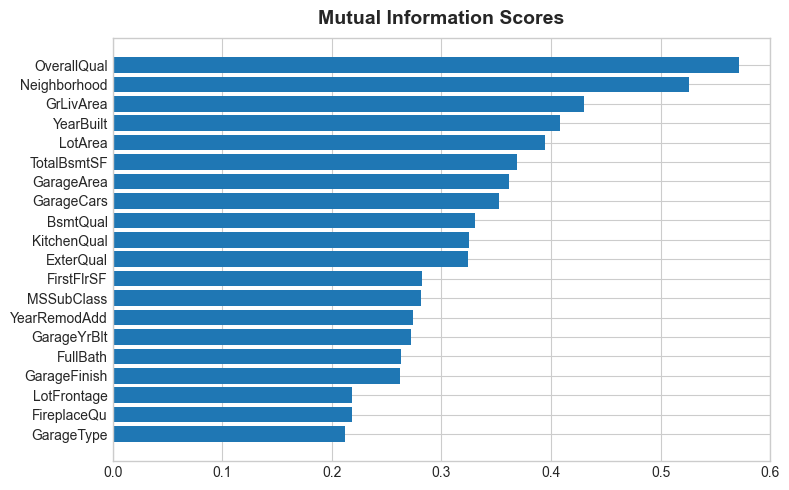

In [20]:
#MI Plot
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")



plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
#plot_mi_scores(mi_scores.tail(20))  


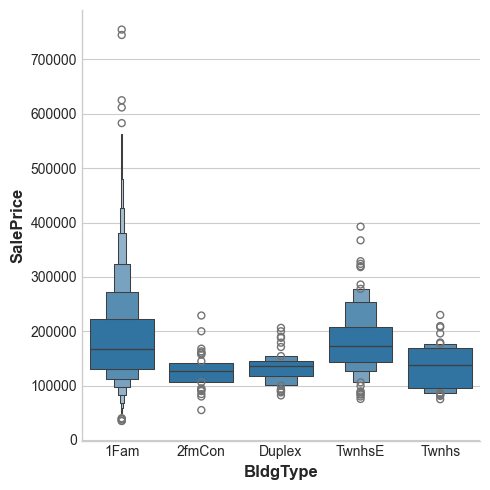

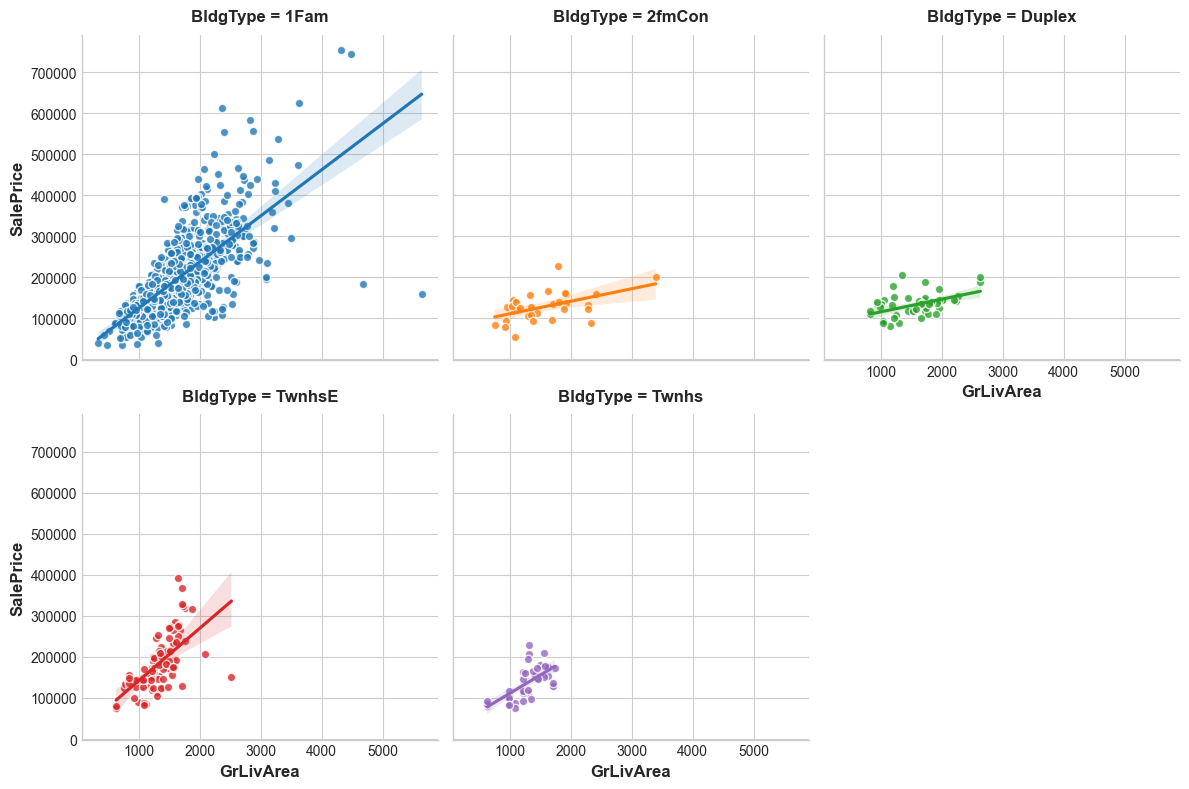

In [21]:
#Feature Interaction
#Catplot
sns.catplot(x="BldgType", y="SalePrice", data=train_inv, kind="boxen");
#Lmplot
feature = "GrLivArea"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=train_inv, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);


In [22]:
#drop 0 MI Score features
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]
